# ANDO: NEW YORK AIRBNB Dataset

## Importation des libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Scikit-learn pour la préparation, la réduction de dimension et le clustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

import warnings	
warnings.filterwarnings('ignore')

## Lecture du dataset

In [27]:
df = pd.read_csv('AB_NYC_2019.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## Tache 1: Nettoyage et preparation

In [28]:
# 1. Remplacer les valeurs manquantes dans reviews_per_month
df['reviews_per_month'].fillna(0, inplace=True)
print("Les valeurs manquantes de reviews_per_month ont été remplacées par 0.")

# 2. Supprimer les colonnes inutiles
to_drop = ['name', 'id', 'last_review']
df.drop(columns=to_drop, inplace=True)
print("Les colonnes name, id et last_review ont été supprimées.")

# 3. Supprimer les valeurs extrêmes dans price avec le 99e percentile
price_cap = df['price'].quantile(0.99)
df = df[df['price'] < price_cap]
df = df[df['price'] > 0]
print(f"Les valeurs extrêmes de price au-dessus de {price_cap} ont été retirées.")

# 4. Créer une nouvelle variable log_price
df['log_price'] = np.log1p(df['price'])
df['log_price'] = df['log_price'].round(2)
print("La variable log_price a été créée à partir de price.")

# 5. Créer les types d'hôtes selon le nombre d'annonces
df['host_type'] = 0
df.loc[df['calculated_host_listings_count'] == 1, 'host_type'] = 0        # Occasionnel
df.loc[(df['calculated_host_listings_count'] >= 2) 
       & (df['calculated_host_listings_count'] <= 5), 'host_type'] = 1    # Multi
df.loc[df['calculated_host_listings_count'] > 5, 'host_type'] = 2         # Opérateur

print("La variable host_type a été créée selon le volume d'annonces.")

# 6. Copier le dataset final
df_cleaned = df.copy()
print("Nettoyage terminé. Le DataFrame propre est prêt pour l'analyse.")
df_cleaned.head()

Les valeurs manquantes de reviews_per_month ont été remplacées par 0.
Les colonnes name, id et last_review ont été supprimées.
Les valeurs extrêmes de price au-dessus de 799.0 ont été retirées.
La variable log_price a été créée à partir de price.
La variable host_type a été créée selon le volume d'annonces.
Nettoyage terminé. Le DataFrame propre est prêt pour l'analyse.


,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,log_price,host_type
0,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,5.01,2
1,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,5.42,1
2,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365,5.02,0
3,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194,4.50,0
4,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0,4.39,0


## Tache 2:  ANALYSE EXPLORATOIRE ET TESTS D'HYPOTHÈSES

In [29]:
# 1 general info
print("DataFrame Info:")
display(df_cleaned.info())

# 2 missing values
print("\nMissing percentile Values in Each Column:")
display(df_cleaned.isnull().sum()/df_cleaned.shape[0] * 100)

# 3 statistical summary
print("\nStatistical Summary of Numerical Columns:")
display(df_cleaned.describe())

# statistical summary categorical
display(df.describe(exclude=['number']))

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 48392 entries, 0 to 48894
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_id                         48392 non-null  int64  
 1   host_name                       48371 non-null  object 
 2   neighbourhood_group             48392 non-null  object 
 3   neighbourhood                   48392 non-null  object 
 4   latitude                        48392 non-null  float64
 5   longitude                       48392 non-null  float64
 6   room_type                       48392 non-null  object 
 7   price                           48392 non-null  int64  
 8   minimum_nights                  48392 non-null  int64  
 9   number_of_reviews               48392 non-null  int64  
 10  reviews_per_month               48392 non-null  float64
 11  calculated_host_listings_count  48392 non-null  int64  
 12  availability_365     

None


Missing percentile Values in Each Column:


host_id                           0.000000
host_name                         0.043396
neighbourhood_group               0.000000
neighbourhood                     0.000000
latitude                          0.000000
longitude                         0.000000
room_type                         0.000000
price                             0.000000
minimum_nights                    0.000000
number_of_reviews                 0.000000
reviews_per_month                 0.000000
calculated_host_listings_count    0.000000
availability_365                  0.000000
log_price                         0.000000
host_type                         0.000000
dtype: float64


Statistical Summary of Numerical Columns:


,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,log_price,host_type
count,4.839200e+04,48392.000000,48392.000000,48392.000000,48392.000000,48392.000000,48392.000000,48392.000000,48392.000000,48392.000000,48392.000000
mean,6.757340e+07,40.728902,-73.951924,137.329145,6.980472,23.419449,1.096973,7.180567,112.014507,4.712931,0.437428
std,7.856254e+07,0.054628,0.046170,103.012234,20.296888,44.706687,1.601271,33.100476,131.208717,0.646657,0.664546
min,2.438000e+03,40.499790,-74.244420,10.000000,1.000000,0.000000,0.000000,1.000000,0.000000,2.400000,0.000000
25%,7.820478e+06,40.689940,-73.982843,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000,4.250000,0.000000
50%,3.080866e+07,40.722885,-73.955480,105.000000,3.000000,5.000000,0.380000,1.000000,44.000000,4.660000,0.000000
75%,1.074344e+08,40.763160,-73.935950,175.000000,5.000000,24.000000,1.600000,2.000000,224.000000,5.170000,1.000000
max,2.743213e+08,40.913060,-73.712990,795.000000,1250.000000,629.000000,58.500000,327.000000,365.000000,6.680000,2.000000


,host_name,neighbourhood_group,neighbourhood,room_type
count,48371,48392,48392,48392
unique,11360,5,220,3
top,Michael,Manhattan,Williamsburg,Entire home/apt
freq,411,21294,3904,25011


In [30]:
# imputer host_name 
df['host_name'].fillna('Unknown', inplace=True)

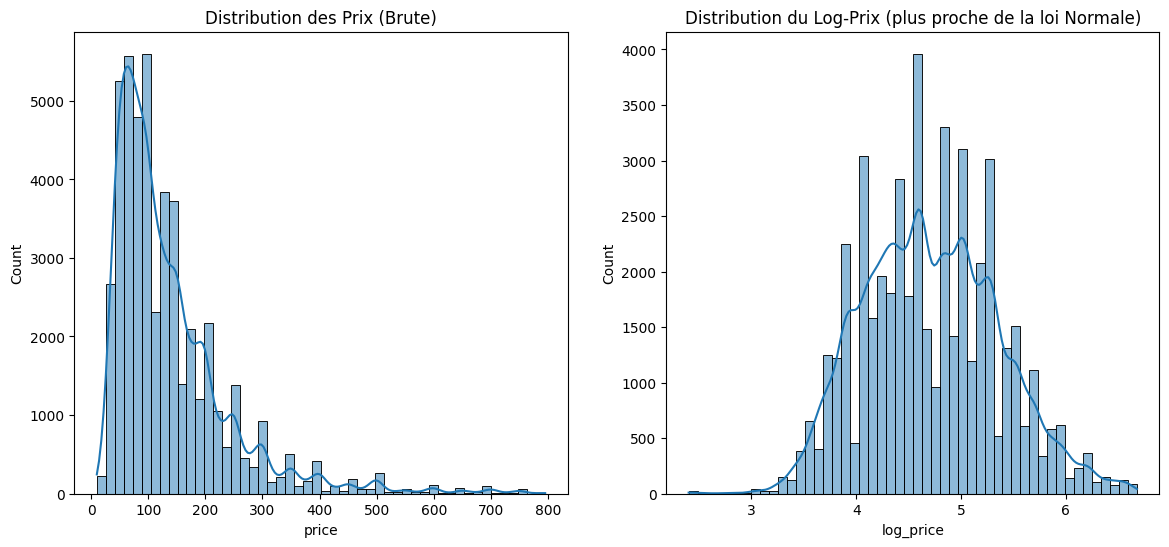

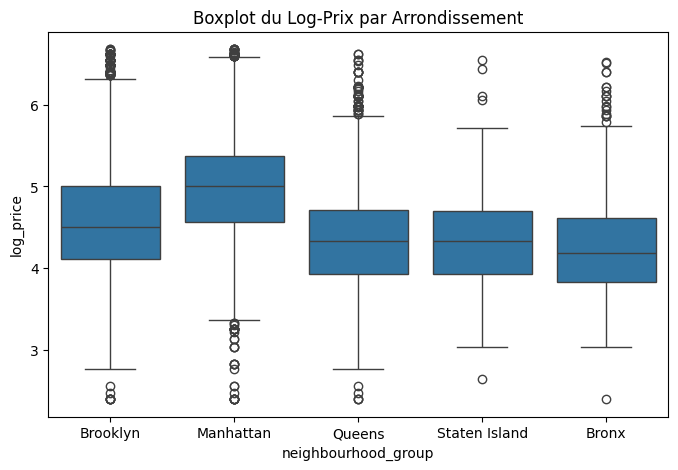

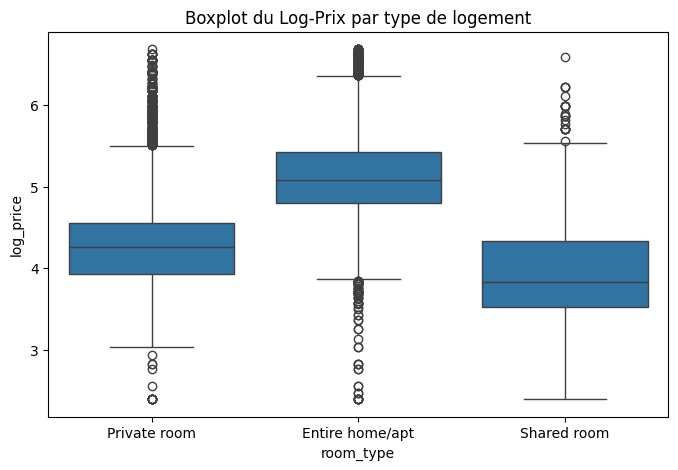

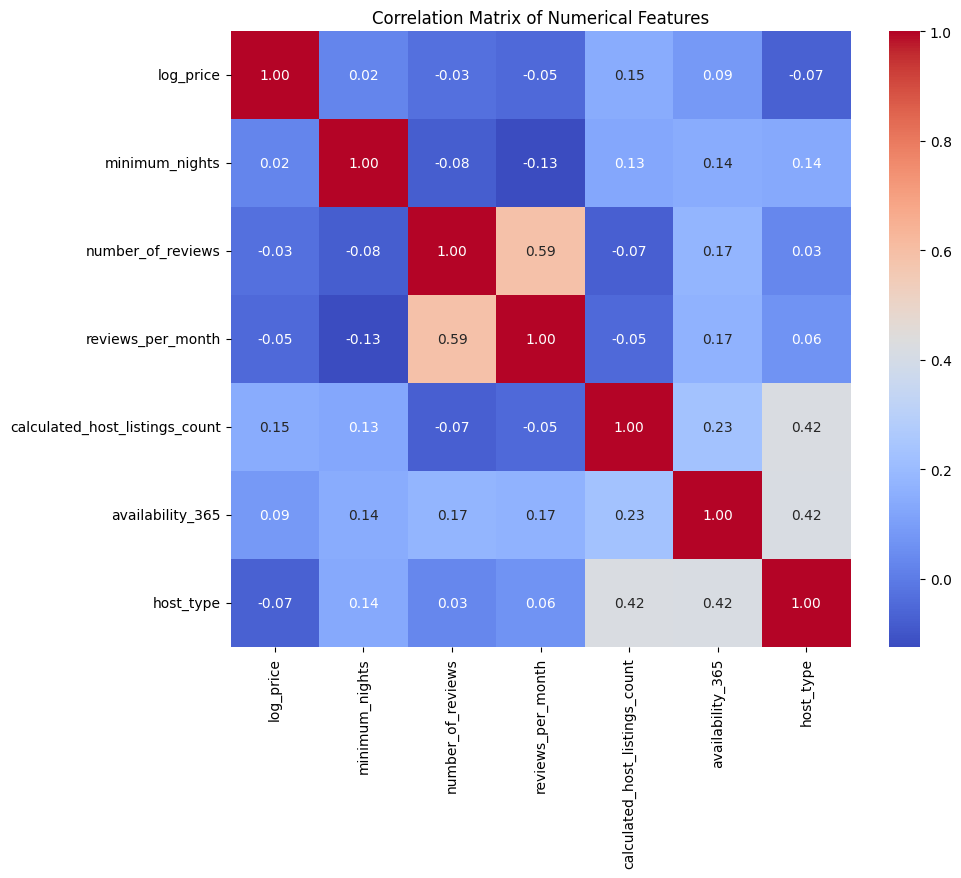

In [32]:
# 1 price distribution
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_cleaned['price'], kde=True, bins=50)
plt.title('Distribution des Prix (Brute)')
# 2 log_price distribution
plt.subplot(1, 2, 2)
sns.histplot(df_cleaned['log_price'], kde=True, bins=50)
plt.title('Distribution du Log-Prix (plus proche de la loi Normale)')
plt.show()

#  3 Bivariate Analysis: Boxplot of log_price by neighbourhood_group
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_cleaned, x='neighbourhood_group', y='log_price')
plt.title('Boxplot du Log-Prix par Arrondissement')
plt.show()

# 4 Bivariate Analysis: Boxplot of log_price by room_type
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_cleaned, x='room_type', y='log_price')
plt.title('Boxplot du Log-Prix par type de logement')
plt.show()


# 5 collation matrix
numerical_cols = ['log_price', 'minimum_nights', 'number_of_reviews', 
                  'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'host_type']
corr_matrix = df_cleaned[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

### Teste d'hypothese

In [33]:
# Hypothesis testing: ANOVA test for log_price across neighbourhood_group
# 1 ANOVA test
groups = [group['log_price'].values for name, group in df_cleaned.groupby('neighbourhood_group')]
f_stat, p_value = stats.f_oneway(*groups)
print(f"ANOVA test results for log_price across neighbourhood_group: F-statistic = {f_stat}, p-value = {p_value}")
if p_value < 0.05:
	print("Reject the null hypothesis: Significant differences exist between groups.")	
else:
	print("Fail to reject the null hypothesis: No significant differences between groups.")
 
 # 2 t-test for log_price between two room_types: 'Shared room' and 'Private room'
entire_home = df_cleaned[df_cleaned['room_type'] == 'Shared room']['log_price']
private_room = df_cleaned[df_cleaned['room_type'] == 'Private room']['log_price']
t_stat, p_value = stats.ttest_ind(entire_home, private_room, equal_var=False)
print(f"T-test results for log_price between 'Shared room' and 'Private room': T-statistic = {t_stat}, p-value = {p_value}")
if p_value < 0.05:		
	print("Reject the null hypothesis: Significant difference in log_price between the two room types.")	
else:
	print("Fail to reject the null hypothesis: No significant difference in log_price between the two room types.")

# 3 Chi-squared test for independence between neighbourhood_group and room_type
contingency_table = pd.crosstab(df_cleaned['neighbourhood_group'], df_cleaned['room_type'])
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-squared test results between neighbourhood_group and room_type: Chi2-statistic = {chi2_stat}, p-value = {p_value}")
if p_value < 0.05:
	print("Reject the null hypothesis: Variables are dependent.")	
else:
	print("Fail to reject the null hypothesis: Variables are independent.")
 
# 4. Tests d'Hypothèses
# Test 1: T-test de Student - Le prix moyen à Manhattan est-il différent de celui de Brooklyn ?
manhattan_prices = df_cleaned[df_cleaned['neighbourhood_group'] == 'Queens']['log_price']
brooklyn_prices = df_cleaned[df_cleaned['neighbourhood_group'] == 'Brooklyn']['log_price']
t_stat, p_value = stats.ttest_ind(manhattan_prices, brooklyn_prices, equal_var=False)
print(f"--- T-test (Manhattan vs Brooklyn) ---")
print(f"P-valeur: {p_value:.5f}")
if p_value < 0.05:
    print("Conclusion : On rejette l'hypothèse nulle. Les prix moyens sont significativement différents.")
else:
    print("Conclusion : On ne peut pas rejeter l'hypothèse nulle.") 

# 5 Test 2: Test du Chi-carré - Y a-t-il une dépendance entre le type de chambre et l'arrondissement ?
contingency_table = pd.crosstab(df_cleaned['neighbourhood_group'], df_cleaned['room_type'])
chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
print(f"\n--- Test du Chi-carré (Arrondissement vs Type de chambre) ---")
print(f"P-valeur: {p_value:.5f}")
if p_value < 0.05:
    print("Conclusion : On rejette l'hypothèse nulle. Il y a une association significative entre les variables.")
else:
    print("Conclusion : On ne peut pas rejeter l'hypothèse nulle.")
display(contingency_table)

# Post-hoc analysis: Tukey's HSD test for neighbourhood_group 
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(df_cleaned['log_price'], df_cleaned['neighbourhood_group'])
print(tukey)

# Post-hoc analysis: Tukey's HSD test for room_type 
tukey_room = pairwise_tukeyhsd(df_cleaned['log_price'], df_cleaned['room_type'])
print(tukey_room)

ANOVA test results for log_price across neighbourhood_group: F-statistic = 1914.1349776549484, p-value = 0.0
Reject the null hypothesis: Significant differences exist between groups.
T-test results for log_price between 'Shared room' and 'Private room': T-statistic = -19.06000319835885, p-value = 3.826822930946871e-71
Reject the null hypothesis: Significant difference in log_price between the two room types.
Chi-squared test results between neighbourhood_group and room_type: Chi2-statistic = 1496.6493493852556, p-value = 0.0
Reject the null hypothesis: Variables are dependent.
--- T-test (Manhattan vs Brooklyn) ---
P-valeur: 0.00000
Conclusion : On rejette l'hypothèse nulle. Les prix moyens sont significativement différents.

--- Test du Chi-carré (Arrondissement vs Type de chambre) ---
P-valeur: 0.00000
Conclusion : On rejette l'hypothèse nulle. Il y a une association significative entre les variables.


room_type,Entire home/apt,Private room,Shared room
neighbourhood_group,,,
Bronx,378,650,59
Brooklyn,9480,10101,411
Manhattan,12894,7923,477
Queens,2087,3368,195
Staten Island,172,188,9


     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1      group2    meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
    Bronx      Brooklyn   0.3128    0.0  0.2617  0.3638   True
    Bronx     Manhattan   0.7182    0.0  0.6673  0.7692   True
    Bronx        Queens    0.125    0.0  0.0707  0.1793   True
    Bronx Staten Island    0.103 0.0359  0.0043  0.2018   True
 Brooklyn     Manhattan   0.4055    0.0  0.3893  0.4216   True
 Brooklyn        Queens  -0.1878    0.0 -0.2125 -0.1631   True
 Brooklyn Staten Island  -0.2098    0.0 -0.2959 -0.1236   True
Manhattan        Queens  -0.5933    0.0 -0.6178 -0.5687   True
Manhattan Staten Island  -0.6152    0.0 -0.7013 -0.5291   True
   Queens Staten Island   -0.022 0.9608   -0.11  0.0661  False
--------------------------------------------------------------
       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
     group1        group2    meandiff p-adj  lower 

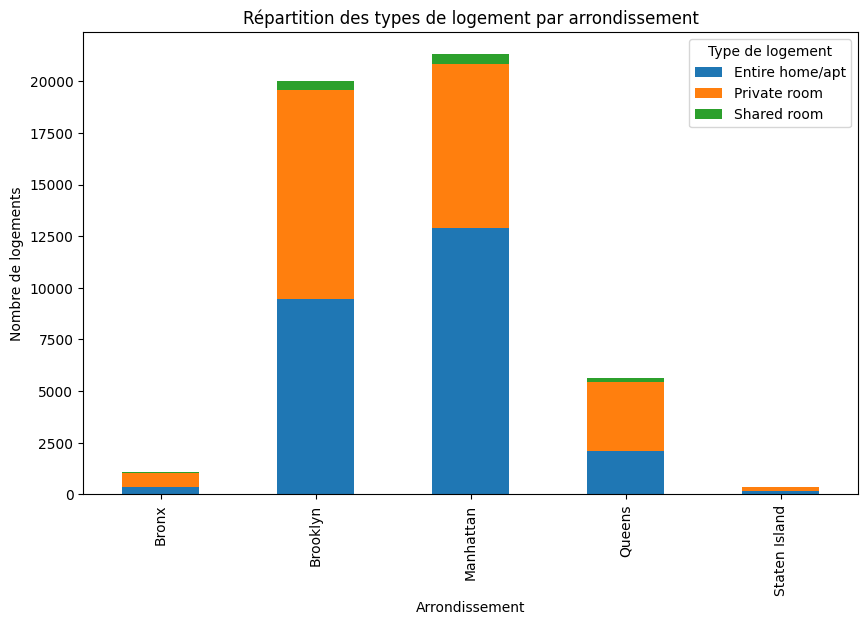

In [34]:
df_room_type_neighbourhood = df.room_type.groupby(df.neighbourhood_group).value_counts().unstack()
df_room_type_neighbourhood.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Répartition des types de logement par arrondissement')
plt.xlabel('Arrondissement')
plt.ylabel('Nombre de logements')
plt.legend(title='Type de logement')
plt.show()

## Tache 3: PCA et CCA


--- Étape 4: Réduction de Dimension ---
--- Lancement de l'ACP ---


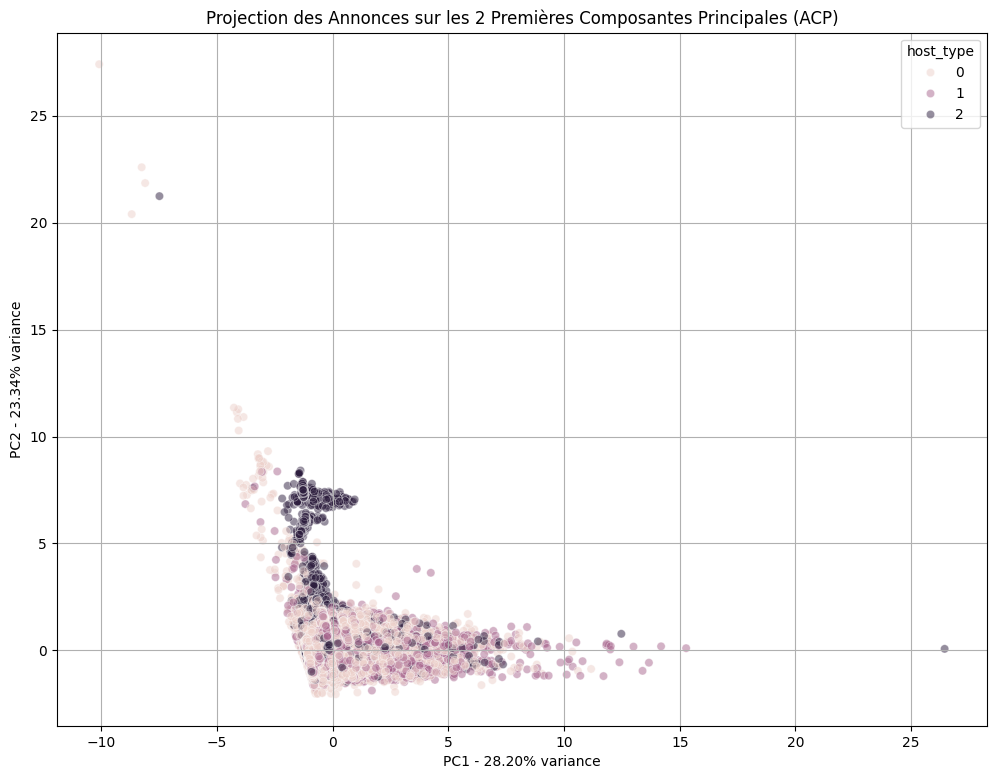

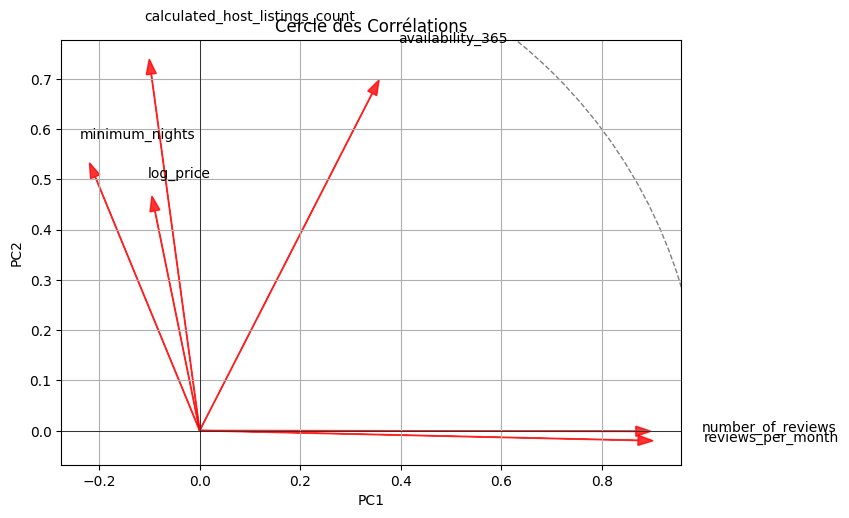


--- Lancement de l'ACM ---


"mca = prince.MCA(n_components=2, n_iter=3, random_state=42)\nmca = mca.fit(df_mca_input)\n\n# CORRECTION #2 : La librairie prince utilise Altair. La syntaxe pour le titre change.\nchart = mca.plot(df_mca_input)\nchart = chart.properties(\n    title='Projection des Modalités sur le Premier Plan Factoriel (ACM)'\n)\nax = mca.plot(df_mca_input)\nplt.show()"

In [59]:
# PARTIE 4 : RÉDUCTION DE DIMENSION (Leçons 3-4-5) - CORRIGÉ #2
print("\n--- Étape 4: Réduction de Dimension ---")

# 1. Analyse en Composantes Principales (ACP) sur les données numériques
print("--- Lancement de l'ACP ---")
features_for_pca = ['log_price', 'minimum_nights', 'number_of_reviews',
                      'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

# Centrer et réduire les données est CRUCIAL pour l'ACP
X = df_cleaned[features_for_pca].values
X_scaled = StandardScaler().fit_transform(X)

# Application de l'ACP
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Ajout des informations qualitatives pour la visualisation
df_pca.index = df_cleaned.index
df_pca['host_type'] = df_cleaned['host_type']

# Visualisation des individus sur le premier plan factoriel
plt.figure(figsize=(12, 9))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='host_type', alpha=0.5)
plt.title('Projection des Annonces sur les 2 Premières Composantes Principales (ACP)')
plt.xlabel(f'PC1 - {pca.explained_variance_ratio_[0]*100:.2f}% variance')
plt.ylabel(f'PC2 - {pca.explained_variance_ratio_[1]*100:.2f}% variance')
plt.grid(True)
plt.show()

# Cercle des corrélations (Interprétation des axes)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
fig, ax = plt.subplots(figsize=(8, 8))
for i, feature in enumerate(features_for_pca):
    ax.arrow(0, 0, loadings[i,0], loadings[i,1], color='r', alpha=0.8, head_width=0.02)
    ax.text(loadings[i,0]*1.15, loadings[i,1]*1.15, feature, color='black')
circle = plt.Circle((0,0), 1, color='gray', fill=False, linestyle='--')
ax.add_artist(circle)
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Cercle des Corrélations')
ax.set_aspect('equal', adjustable='box')
ax.grid(True)
plt.show()

# 2. Analyse des Correspondances Multiples (ACM) sur les données catégorielles
print("\n--- Lancement de l'ACM ---")
df_cleaned['price_category'] = pd.qcut(df_cleaned['price'], q=3, labels=['Bas', 'Moyen', 'Élevé'])
features_for_mca = ['neighbourhood_group', 'room_type', 'price_category']
df_mca_input = df_cleaned[features_for_mca]

'''mca = prince.MCA(n_components=2, n_iter=3, random_state=42)
mca = mca.fit(df_mca_input)

# CORRECTION #2 : La librairie prince utilise Altair. La syntaxe pour le titre change.
chart = mca.plot(df_mca_input)
chart = chart.properties(
    title='Projection des Modalités sur le Premier Plan Factoriel (ACM)'
)
ax = mca.plot(df_mca_input)
plt.show()'''

## Tâche 4: Clustering et segmentation des hôtes


--- Étape 5: Clustering ---
--- Lancement du K-Means ---


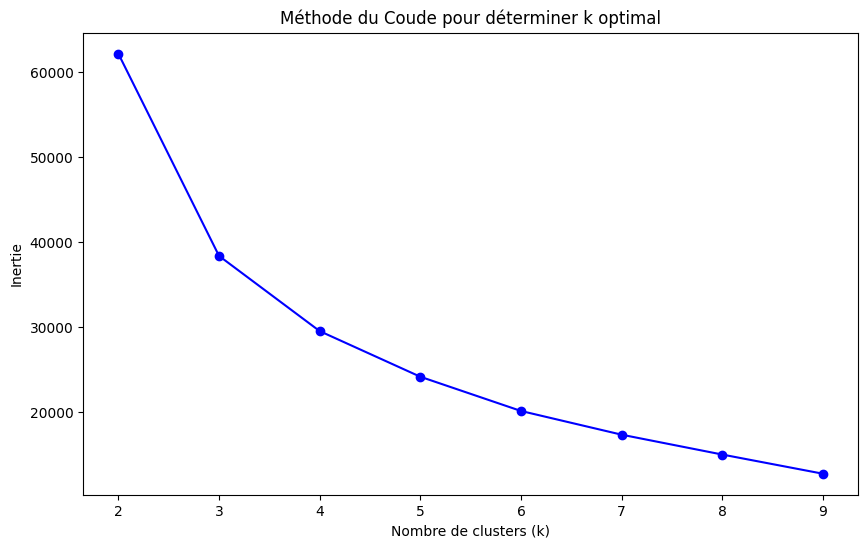

Clustering K-Means avec k=3 terminé.


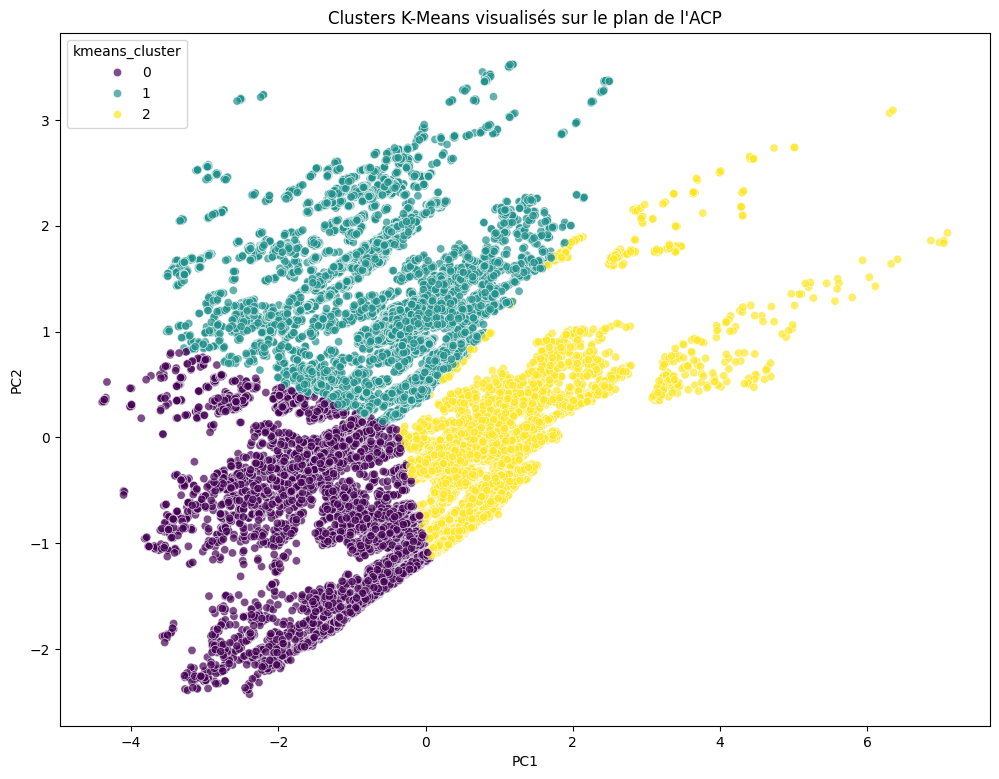

Profil moyen des clusters (sur données non-standardisées) :
                log_price  minimum_nights  number_of_reviews  \
kmeans_cluster                                                 
0                4.557019        5.241341          25.242464   
1                4.643559        9.972049          26.850754   
2                4.831282        6.096038          20.501550   

                reviews_per_month  calculated_host_listings_count  \
kmeans_cluster                                                      
0                        1.215269                        1.453485   
1                        1.287096                       22.579404   
2                        0.926679                        1.020155   

                availability_365  host_type  
kmeans_cluster                               
0                     103.235726   0.239008  
1                     183.437955   1.334093  
2                      74.573945   0.011370  

--- Lancement du DBSCAN ---
Clustering spa

In [57]:
# PARTIE 5 : CLUSTERING (Leçon 6)
print("\n--- Étape 5: Clustering ---")

# 1. K-Means sur les composantes principales de l'ACP
print("--- Lancement du K-Means ---")
# On utilise les données de l'ACP pour le clustering
X_for_kmeans = df_pca[['PC1', 'PC2']].values

# Détermination du nombre optimal de clusters (Méthode du coude)
inertia = []
K_range = range(2, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_for_kmeans)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.title('Méthode du Coude pour déterminer k optimal')
plt.show()

# On choisit k=4 (un coude visible)
k_optimal = 3
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
df_pca['kmeans_cluster'] = kmeans.fit_predict(X_for_kmeans)
print(f"Clustering K-Means avec k={k_optimal} terminé.")

# Visualisation des clusters K-Means
plt.figure(figsize=(12, 9))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='kmeans_cluster', palette='viridis', alpha=0.7)
plt.title('Clusters K-Means visualisés sur le plan de l\'ACP')
plt.show()

# Interprétation des clusters
cluster_profile = df_cleaned.join(df_pca['kmeans_cluster'])
print("Profil moyen des clusters (sur données non-standardisées) :")
print(cluster_profile.groupby('kmeans_cluster')[numerical_cols].mean())


# 2. DBSCAN pour le clustering spatial
print("\n--- Lancement du DBSCAN ---")
# On prend un échantillon pour des raisons de performance
df_sample_spatial = df_cleaned.sample(n=20000, random_state=42)
coords = df_sample_spatial[['latitude', 'longitude']].values

# Les paramètres eps et min_samples sont cruciaux et nécessitent des tests.
# eps=0.01 (environ 1km à NYC), min_samples=50
dbscan = DBSCAN(eps=0.01, min_samples=50)
df_sample_spatial['dbscan_cluster'] = dbscan.fit_predict(coords)
print("Clustering spatial DBSCAN terminé.")
print(f"Nombre de clusters trouvés : {df_sample_spatial['dbscan_cluster'].nunique() - 1}")
print(f"Nombre de points 'bruit' (outliers) : {(df_sample_spatial['dbscan_cluster'] == -1).sum()}")

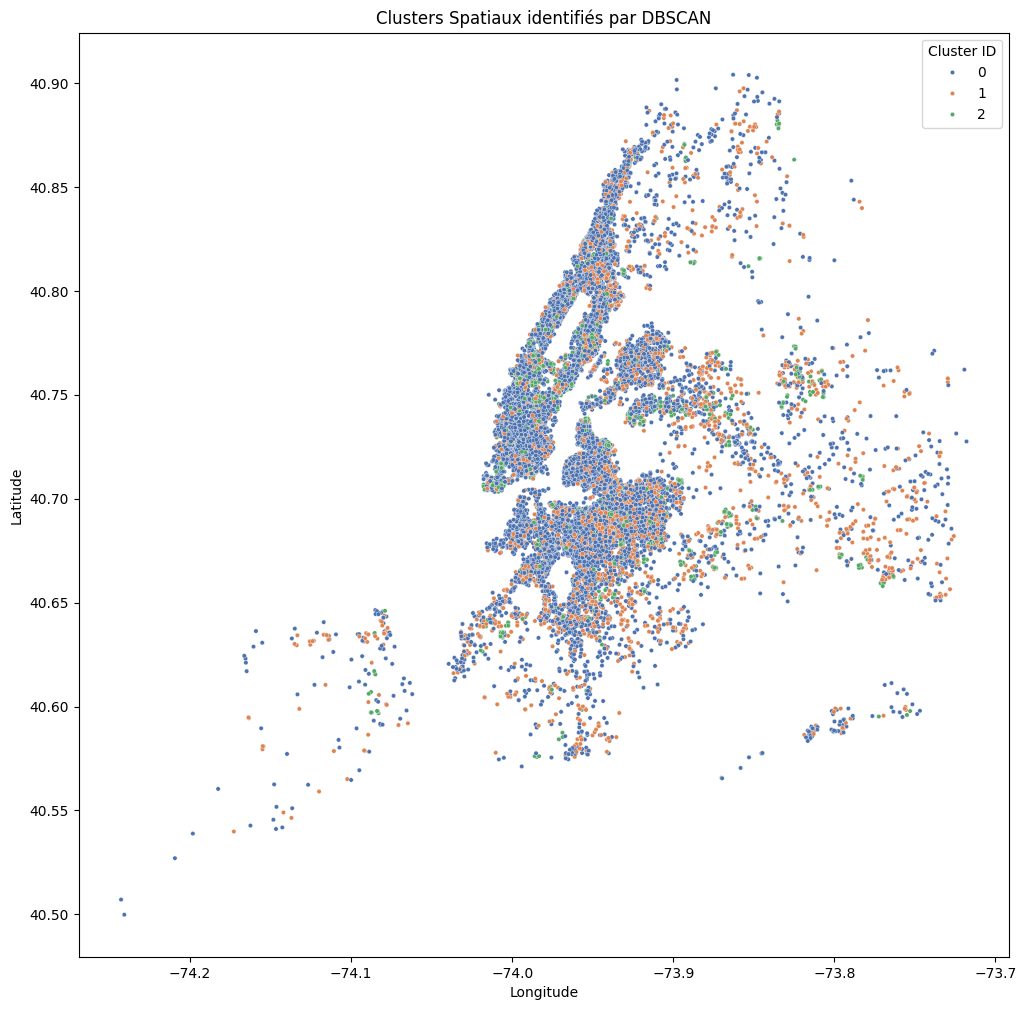

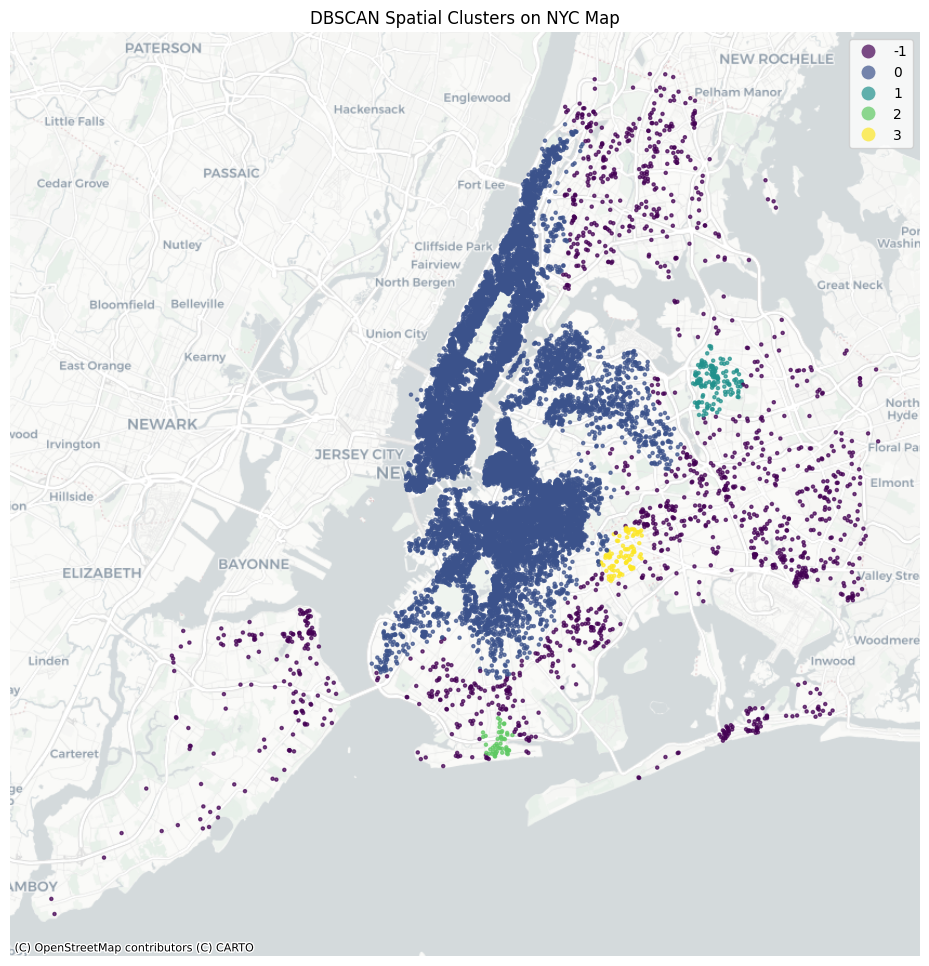

In [55]:
import geopandas as gpd
import contextily as ctx

# Visualisation des clusters DBSCAN
plt.figure(figsize=(12, 12))
sns.scatterplot(data=df_sample_spatial, x='longitude', y='latitude', 
                hue='host_type', palette='deep', s=10, 
                legend='full')
plt.title('Clusters Spatiaux identifiés par DBSCAN')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Cluster ID')
plt.show()

gdf_spatial = gpd.GeoDataFrame(
    df_sample_spatial,
    geometry=gpd.points_from_xy(df_sample_spatial.longitude, df_sample_spatial.latitude),
    crs="EPSG:4326"
).to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 12))
gdf_spatial.plot(
    ax=ax,
    column='dbscan_cluster',
    categorical=True,
    cmap='viridis',
    markersize= 5,
    alpha=0.7,
    legend=True
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.title('DBSCAN Spatial Clusters on NYC Map')
plt.show()

## Tâche 5. Analyse spatiale et modèle explicatif
